# Test-Driving Particle Filter: Python Implementation on Stock Prices

In [1]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

In [2]:
import numpy as np
import pandas as pd

#Plotting and Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [ ]:
# https://filterpy.readthedocs.io/en/latest/index.html
# !pip install filterpy

In [ ]:
import filterpy
filterpy.__version__

In [39]:
ticker_symbol = "AAPL"  #  Apple Inc. 
start_date = "2020-01-01"
end_date = "2024-10-01"
stock_data = get_stock_data(ticker_symbol, start_date, end_date)
stock_data.asfreq('B').index  # set index frequency to business daliy
stock_data.info()

[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1194 entries, 2020-01-02 to 2024-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1194 non-null   float64
 1   High       1194 non-null   float64
 2   Low        1194 non-null   float64
 3   Close      1194 non-null   float64
 4   Adj Close  1194 non-null   float64
 5   Volume     1194 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 97.6 KB


In [40]:
stock_data['Daily_Return'] = stock_data['Close'].pct_change()
stock_data.dropna(inplace=True)

In [42]:
from scipy.stats import kstest, t

# Fit the data using t-distribution
params = t.fit(stock_data['Daily_Return'])
d, p_value = kstest(stock_data['Daily_Return'], 't', args=params)
print(f"KS Statistic: {d}, P-Value: {p_value}")

if p_value > 0.05:
    print('Sample fits the t-distribution (fail to reject H0)')
else:
    print('Sample does not fit the t-distribution (reject H0)')

KS Statistic: 0.016853826692910967, P-Value: 0.8811848298074427
Sample fits the t-distribution (fail to reject H0)


Degrees of Freedom: 3.647778976817248, Mean: 0.0011778852859006973, Standard Deviation: 0.014017215685009849


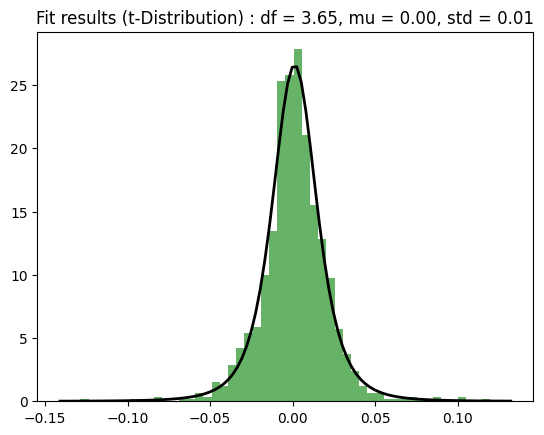

In [41]:
from scipy.stats import t

# Fit a t-distribution to the daily return data
params = t.fit(stock_data['Daily_Return'])

# Get the parameters
dfree, mu, std = params
print(f"Degrees of Freedom: {dfree}, Mean: {mu}, Standard Deviation: {std}")

# Plot the histogram and the PDF
plt.hist(stock_data['Daily_Return'], bins=50, density=True, alpha=0.6, color='g')

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = t.pdf(x, dfree, mu, std)

plt.plot(x, p, 'k', linewidth=2)
title = f"Fit results (t-Distribution) : df = {dfree:.2f}, mu = {mu:.2f}, std = {std:.2f}"
plt.title(title)

plt.show()

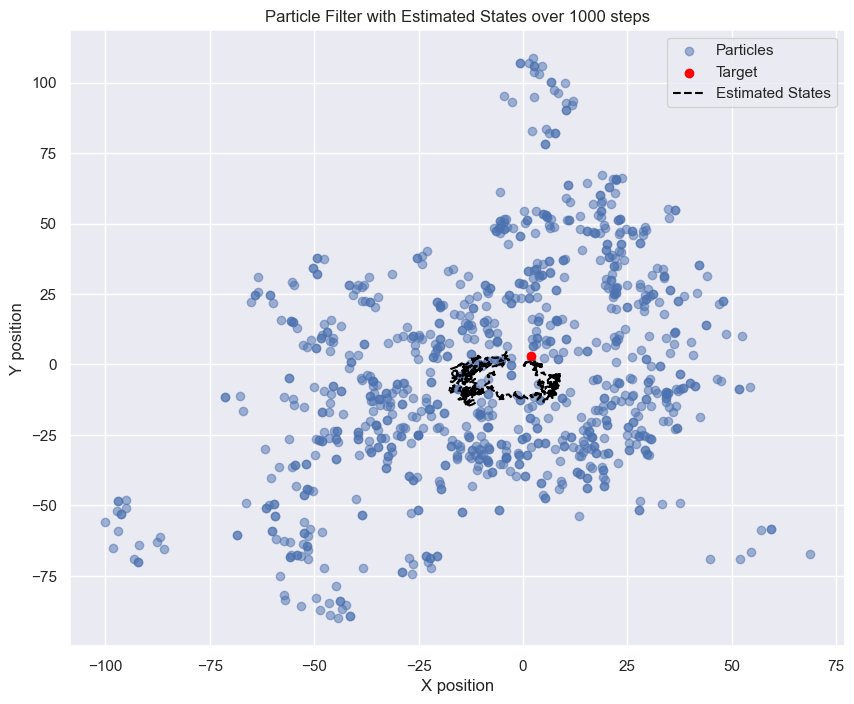

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.monte_carlo import systematic_resample
from numpy.random import uniform, laplace

# Define the number of particles
num_particles = 1000

# 1. Randomly generate a bunch of particles
particles = uniform(-10, 10, (num_particles, 2))

# Define the state transition function (robot movement) using Laplace distribution
def predict(particles):
    movement_noise = laplace(0, 1, particles.shape)  # Non-Gaussian noise
    return particles + movement_noise

# Define the measurement function (sensor reading)
def measure_distance(particles, target):
    distances = np.linalg.norm(particles - target, axis=1)
    measurement_noise = laplace(0, 1, size=distances.shape)  # Non-Gaussian noise
    return distances + measurement_noise

# Define the likelihood function (importance weight)
def update(particles, weights, target, measured_distance):
    predicted_distances = np.linalg.norm(particles - target, axis=1)
    weights *= np.exp(-0.5 * (predicted_distances - measured_distance)**2)
    weights += 1.e-300  # avoid round-off to zero
    weights /= np.sum(weights)  # normalize
    return weights

# Set the target position (hidden state)
target = np.array([2, 3])

# Initialize weights
weights = np.ones(num_particles) / num_particles

# Store estimated states
estimated_states = []

# Simulate the particle filter over multiple steps
steps = 1000
for _ in range(steps):
    # 2. Predict next state of the particles
    particles = predict(particles)
    
    # 3. Update the weighting of the particles based on the measurement
    measured_distance = measure_distance(particles, target)
    weights = update(particles, weights, target, measured_distance)
    
    # 4. Resample
    indices = systematic_resample(weights)
    particles = particles[indices]
    weights.fill(1.0 / num_particles)
    
    # 5. Compute estimate
    estimated_state = np.mean(particles, axis=0)
    estimated_states.append(estimated_state)
    #print(f"Estimated state: {estimated_state}")

# Convert estimated states to a NumPy array for plotting
estimated_states = np.array(estimated_states)

# Plot the final particles and the target position
plt.figure(figsize=(10, 8))
plt.scatter(particles[:, 0], particles[:, 1], alpha=0.5, label='Particles')
plt.scatter(target[0], target[1], color='red', label='Target')
plt.plot(estimated_states[:, 0], estimated_states[:, 1], color='black', label='Estimated States', linestyle='--')
plt.title(f'Particle Filter with Estimated States over {steps} steps')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.legend()
#plt.show()

# Save the figure
plt.savefig('pf_2d.jpg')

[*********************100%%**********************]  1 of 1 completed



Best parameters: Particles: 13000, Process_Std: 10.0, measurement_Std: 1.0, DoF: 30


Execution time for grid search: 0 hours, 34 minutes, 33 seconds

Training Set Metrics:
MAE: 0.0247
MSE: 0.0010
RMSE: 0.0321
MAPE: 0.0191
R2: 1.0000

Testing Set Metrics:
MAE: 0.0270
MSE: 0.0013
RMSE: 0.0354
MAPE: 0.0139
R2: 1.0000


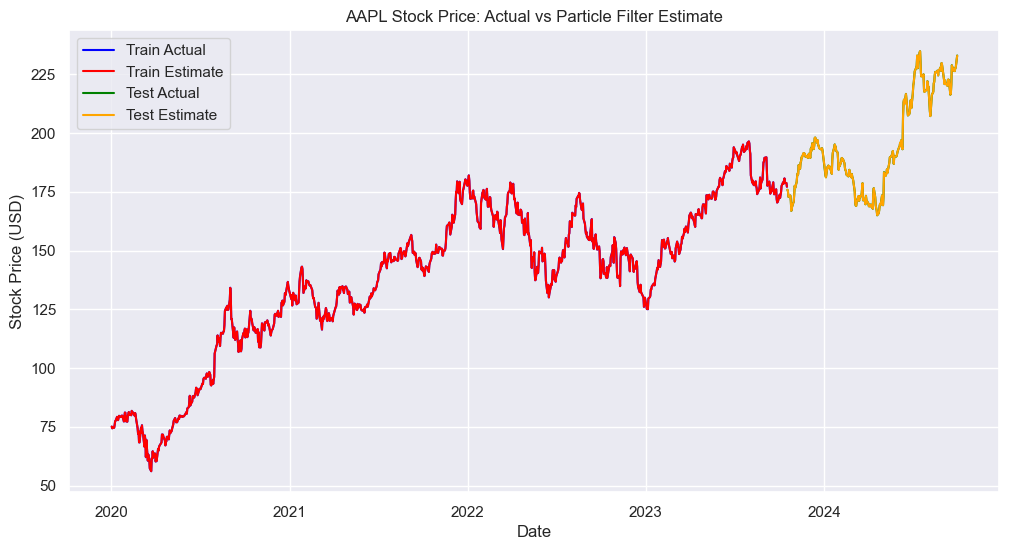

In [3]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t as students_t
from filterpy.monte_carlo import systematic_resample, stratified_resample
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import pandas as pd
from itertools import product
import time  
start_time = time.time()  

# Fetch AAPL stock data
data = yf.download("AAPL", start="2020-01-01", end="2024-10-01")
stock_prices = data['Close'].values

def particle_filter(measurements, num_particles, process_std, measurement_std, degrees_of_freedom):
    estimates = []
    
    # 1. Randomly generate initial particles
    particles = np.random.normal(measurements[0], process_std, num_particles)
    
    for measurement in measurements:
        # 2. Predict next state of the particles (State equation / transition model)
        particles = predict_particles(particles, process_std)
        
        # 3. Update the weighting of the particles based on the measurement (Measurement equation / observation model)
        weights = update_weights(particles, measurement, degrees_of_freedom, measurement_std)
        
        # 4. Resample
        particles = resample_particles(particles, weights)
        
        # 5. Compute Estimate
        estimate = compute_estimate(particles)
        estimates.append(estimate)
    
    return estimates

def predict_particles(particles, process_std):
    """State equation / transition model"""
    return particles + np.random.normal(0, process_std, len(particles))

def update_weights(particles, measurement, degrees_of_freedom, process_std):
    """Measurement equation / observation model"""
    weights = students_t.pdf(measurement, df=degrees_of_freedom, loc=particles, scale=process_std)
    weights += 1.e-300  # Avoid divide by zero
    return weights / np.sum(weights)

def resample_particles(particles, weights):
    indices = systematic_resample(weights)
    return particles[indices]

def compute_estimate(particles):
    return np.mean(particles)

# Grid search parameters
num_particles_range = [5000, 7000, 10000, 13000]
process_std_range = [2.0, 5.0, 7.0, 10.0]
measurement_std_range = [1.0, 2.0, 5.0]
degrees_of_freedom_range = [5, 10, 15, 20, 25, 30]

best_r2 = -np.inf
best_params = None

# Perform grid search
for num_particles, process_std, measurement_std, degrees_of_freedom in product(num_particles_range, process_std_range, measurement_std_range, degrees_of_freedom_range):
    estimates = particle_filter(stock_prices, num_particles, process_std, measurement_std, degrees_of_freedom)
    r2 = r2_score(stock_prices, estimates)
    
    if r2 > best_r2:
        best_r2 = r2
        best_params = (num_particles, process_std, measurement_std, degrees_of_freedom)
    
    #print(f"Particles: {num_particles}, Process_Std: {process_std}, Measurement_Std: {measurement_std}, DoF: {degrees_of_freedom}, R2: {r2:.4f}")

print(f"\nBest parameters: Particles: {best_params[0]}, Process_Std: {best_params[1]}, measurement_Std: {best_params[2]}, DoF: {best_params[3]}")

print("\n")
end_time = time.time()  
execution_time = end_time - start_time  
hours, remainder = divmod(execution_time, 3600)  
minutes, seconds = divmod(remainder, 60)   
print(f"Execution time for grid search: {int(hours)} hours, {int(minutes)} minutes, {int(seconds)} seconds")

#=================================================================================================================
#
#
# Split data into training and testing sets
train_prices, test_prices = train_test_split(stock_prices, test_size=0.2, shuffle=False)

# Run particle filter with best parameters on both sets
train_estimates = particle_filter(train_prices, best_params[0], best_params[1], best_params[2], best_params[3])
test_estimates = particle_filter(test_prices, best_params[0], best_params[1], best_params[2], best_params[3])

def calculate_metrics(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    r2 = r2_score(actual, predicted)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "MAPE": mape, "R2": r2}

# Calculate metrics for both sets
train_metrics = calculate_metrics(train_prices, train_estimates)
test_metrics = calculate_metrics(test_prices, test_estimates)

# Print metrics
print("\nTraining Set Metrics:")
for metric, value in train_metrics.items():
    print(f"{metric}: {value:.4f}")

print("\nTesting Set Metrics:")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(data.index[:len(train_prices)], train_prices, label='Train Actual', color='blue')
plt.plot(data.index[:len(train_prices)], train_estimates, label='Train Estimate', color='red')
plt.plot(data.index[len(train_prices):], test_prices, label='Test Actual', color='green')
plt.plot(data.index[len(train_prices):], test_estimates, label='Test Estimate', color='orange')
plt.title('AAPL Stock Price: Actual vs Particle Filter Estimate')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid(True)
#plt.show()

# Save the figure
plt.savefig('pf_stock.jpg')